# Quantum Jet Classifier

The aim of this project is to produce a jet classifier using a quantum graph neural network.

This project is inspired of the following article: [*JEDI-net: a jet identification algorithm based on interaction networks*](https://arxiv.org/abs/1908.05318)

This project was implemented on FPGAs with a simplified dataset (see [https://ipa.phys.ethz.ch/education/colloquium-ipa/current_semester.html](https://ipa.phys.ethz.ch/education/colloquium-ipa/current_semester.html)). This simplified version will be used as a reference for the current project.



## I. Circuit implementation

The circuit takes a list of $N_p$ particles as an input. Each particle has $N_f$ features. 

A fully connected graph is first built the following way: 
- Each node corresponds to a particle and contains its features.
- Each edge represents the concatenation of the features of the two corresponding nodes. 

A first circuit (for now a MLP) will transform the edges to a latent dimension (of dim $D_l$).

The resulting graph structure is then embedded into a quantum circuit using angle encoding.

The quantum circuit measurement gives the classification values. 

In [3]:
import pennylane as qml
import torch
from torch import nn
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.nn import Sequential
import networkx as nx
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.classification import MultilabelAccuracy, MultilabelROC

%load_ext tensorboard

try:
  import tensorboardX
except ModuleNotFoundError:
  %pip install tensorboardX
  import tensorboardX

### 1. Building the dataset

The data come from https://zenodo.org/records/3602260

It contains high-level features, but only restrained information are kept: for the N most energetic particles, $p_T, \eta,\phi$

Then a graph structure is built using a fully connected graph from networkx. 
The nodes have the information of the particles. The edge represent the concatenation of the information of each pair of nodes.

In [4]:
#This part of the program is adapted from https://github.com/bb511/deepsets_synth/blob/main/fast_deepsets/data/data.py

# Handles the data importing and small preprocessing for the interaction network.

import os
import sys
from pathlib import Path
import wget
import tarfile

import h5py
import numpy as np
import sklearn.model_selection
# import tensorflow as tf
qJetClassifier_path = os.path.abspath("/data/tdesrous/qJetClassifier")
sys.path.append(qJetClassifier_path)

print(sys.path)

from qJetClassifier import fit_standardisation, apply_standardisation
# from fast_deepsets.data import plots

class HLS4MLData150(object):
    """Data class for importing and processing the jet data.

    The raw data is available at https://zenodo.org/records/3602260.
    See Moreno et. al. 2019 - JEDI-net: a jet identification algorithm for a full
    description of this data set, section 3.

    Args:
        root: The root directory of the data. It should contain a 'raw' and 'processed'
            folder with raw and processed data. Otherwise, these will be generated.
        nconst: The number of constituents the jet data should be sampled down to.
            The raw number of constituents is 150.
        feats: Which feature selection scheme should be applied. 'ptetaphi' for getting
            the transverse momentum, pseudo-rapidity, and azimuthal angle of each
            cosntituents for every jet. Otherwise, 'all' gets all the features of
            each constituents.
        norm: What kind of normalisation to apply to the features of the data.
            Currently implemented: minmax, robust, or standard.
        train: Whether to import the training data (True) or validation data (False)
            of this data set.
        seed: If provided, shuffles the *constituents* in the data set with given seed.
    """
    def __init__(
        self,
        root: str,
        nconst: int,
        feats: str,
        norm: str,
        train: bool,
        kfolds: 0,
        seed: int = None
    ):
        super().__init__()
        self.root = Path(root)
        self.nconst = nconst
        self.norm = norm
        self.feats = feats
        self.train = train
        self.type = "train" if self.train else "val"
        self.seed = seed
        self.min_pt = 2
        self.kfolds = kfolds

        self.train_url = (
            "https://zenodo.org/records/3602260/files/hls4ml_LHCjet_150p_train.tar.gz"
        )
        self.test_url = (
            "https://zenodo.org/records/3602260/files/hls4ml_LHCjet_150p_val.tar.gz"
        )

        self.preproc_output_name = f"{self.type}_{self.nconst}const.npy"
        self.proc_output_name = (
            f"{self.type}_{self.norm}_{self.nconst}const_{self.feats}.npy"
        )
        os.umask(0)
        self.data_file_dir = self._get_raw_data()
        self.x = None
        self.y = None
        self._get_processed_data()
        self._kfold()

        self.njets = self.x.shape[0]
        self.nfeats = self.x.shape[-1]

    def _get_raw_data(self) -> str:
        """Downloads and unzips the raw data if it does not exist.

        This method checks the given root directory specified the init of the class.
        This root directory should have a specific structure, with the raw data files in
        a subfolder called "raw".
        """
        os.umask(0)
        if not self._check_raw_data_exists():
            self._download_data()

        return self.root / "raw" / self.type

    def _check_raw_data_exists(self) -> bool:
        """Checks if the data exists in the given root dir or needs to be downloaded."""
        os.umask(0)
        if self.root.is_dir():
            raw_dir = self.root / "raw"
            if raw_dir.is_dir():
                data_dir = raw_dir / self.type
                if data_dir.is_dir():
                    if any(data_dir.iterdir()):
                        return 1

        return 0

    def _check_preprocessed_data_exists(self) -> bool:
        """Checks if the preprocessed data exisits or needs to be re-processed."""
        if self.root.is_dir():
            preproc_folder = self.root / "preprocessed"
            x_preproc_file = preproc_folder / f"x_{self.preproc_output_name}"
            y_preproc_file = preproc_folder / f"y_{self.preproc_output_name}"

            if x_preproc_file.is_file() and y_preproc_file.is_file():
                self.x_preprocessed = np.load(x_preproc_file)
                self.y_preprocessed = np.load(y_preproc_file)
                return 1

        return 0

    def _check_processed_data_exists(self) -> bool:
        """Checks if the processed data exisits or needs to be re-processed."""
        if self.root.is_dir():
            proc_folder = self.root / "processed"
            x_proc_file = proc_folder / f"x_{self.proc_output_name}"
            y_proc_file = proc_folder / f"y_{self.proc_output_name}"

            if x_proc_file.is_file() and y_proc_file.is_file():
                self.x = np.load(x_proc_file)
                self.y = np.load(y_proc_file)
                return 1

        return 0

    def _download_data(self):
        """Downloads the jet data if it does not already exist."""
        raw_dir = self.root / "raw"
        os.umask(0)
        if not raw_dir.is_dir():
            os.makedirs(raw_dir)

        if self.train:
            data_file_path = wget.download(self.train_url, out=str(raw_dir))
        else:
            data_file_path = wget.download(self.test_url, out=str(raw_dir))

        print("")
        data_tar = tarfile.open(data_file_path, "r:gz")
        data_tar.extractall(str(raw_dir))
        data_tar.close()
        os.remove(data_file_path)

    def _import_raw_data(self) -> tuple[np.ndarray, np.ndarray]:
        """Imports the raw data files into a numpy array."""
        dfiles = list(file for file in self.data_file_dir.iterdir() if file.is_file())
        data = h5py.File(dfiles[0])
        self.x_raw = data["jetConstituentList"]
        self.y_raw = data["jets"][:, -6:-1]

        for file_path in dfiles[1:]:
            data = h5py.File(file_path)
            add_x_data = data["jetConstituentList"]
            add_y_data = data["jets"][:, -6:-1]
            self.x_raw = np.concatenate((self.x_raw, add_x_data), axis=0)
            self.y_raw = np.concatenate((self.y_raw, add_y_data), axis=0)

    def _preproc_raw_data(self):
        """Applies preprocessing to the raw data.

        The raw data contains jets (samples), each comprising up to 150 particle
        constituents. Every constituent has a feature called transverse momentum which
        describes, loosely speaking, the energy of the particle. This method filters
        out all jet constituents that have this transverse momentum below a given
        minimum threshold. Additionally, the constituents in the raw data are
        ordered in descending order of tranverse momentum value. The first n
        constituents are taken for each jet, where n is a number between 1 and 150.
        """
        self.x_preprocessed = np.copy(self.x_raw)
        del self.x_raw
        self.y_preprocessed = np.copy(self.y_raw)
        del self.y_raw
        self._cut_transverse_momentum()
        self._restrict_nb_constituents()

        preproc_dir = self.root / "preprocessed"
        if not preproc_dir.is_dir():
            os.makedirs(preproc_dir)
        np.save(preproc_dir / f"x_{self.preproc_output_name}", self.x_preprocessed)
        np.save(preproc_dir / f"y_{self.preproc_output_name}", self.y_preprocessed)

    def _process_data(self):
        """Processes the already processed data.

        Namely, certain features are selected for each constituent of each jet.
        Furthermore, each feature is normalized, using a certain normalization scheme.
        For example, minmax normalization.
        """
        self.x = np.copy(self.x_preprocessed)
        del self.x_preprocessed
        self.y = np.copy(self.y_preprocessed)
        del self.y_preprocessed

        proc_folder = self.root / "processed"
        self._get_features()
        norm_params = self._get_normalisation_params()

        self.x = apply_standardisation(self.norm, self.x, norm_params)
        if self.seed and self.train:
            self.shuffle_constituents(self.seed)
        self._plot_data()

        if not proc_folder.is_dir():
            os.makedirs(proc_folder)
        proc_folder = self.root / "processed"
        np.save(proc_folder / f"x_{self.proc_output_name}", self.x)
        np.save(proc_folder / f"y_{self.proc_output_name}", self.y)

        # Free up memory after finishing the preprocessing.
        del self.x
        del self.y
        self.x = np.load(proc_folder / f"x_{self.proc_output_name}")
        self.y = np.load(proc_folder / f"y_{self.proc_output_name}")

    def _get_normalisation_params(self) -> list[float]:
        """Computes the normalisation parameters on the training data.

        For example, computes the mean and standard deviation of a feature on the
        training data and then applies it to the validation data.
        This is done such that no information on the validation data is used before
        passing it through the machine learning algorithm.
        """
        proc_folder = self.root / "processed"
        if not self.train:
            train_data_name = proc_output_name = (
                f"train_{self.norm}_{self.nconst}const_{self.feats}.npy"
            )
            try:
                x_data_train = np.load(proc_folder / f"x_{train_data_name}")
            except OSError as e:
                print("Process training data with same hyperparameters first!")
                print("Need for normalisation of the validation data.")
                exit(1)

            return fit_standardisation(self.norm, self.x)

        return fit_standardisation(self.norm, self.x)

    def _get_processed_data(self):
        """Imports the processed data if it exists. If not, generates it."""
        if not self._check_processed_data_exists():
            if not self._check_preprocessed_data_exists():
                self._import_raw_data()
                self._preproc_raw_data()

            self._process_data()

    def _plot_data(self):
        """Plots the normalised data."""
        print("Plotting data...")
        # plots_folder = self.root / f"plots_{self.norm}_{self.nconst}const_{self.feats}"
        # if not plots_folder.is_dir():
        #     os.makedirs(plots_folder)

        # plots.constituent_number(plots_folder, self.x, self.type)
        # plots.normalised_data(plots_folder, self.x, self.y, self.type, self.feats)

    def _get_features(self) -> np.ndarray:
        """Choose what feature selection to employ on the data. Return shape."""
        switcher = {
            "ptetaphi": lambda: self._select_features_ptetaphi(self.x),
            "allfeats": lambda: self._select_features_all(self.x),
        }

        self.x = switcher.get(self.feats, lambda: None)()
        if self.x is None:
            raise TypeError("Feature selection name not valid!")

    def _select_features_ptetaphi(self, data: np.ndarray) -> np.ndarray:
        """Selects (pT, etarel, phirel) features from the numpy jet array."""
        return data[:, :, [5, 8, 11]]

    def _select_features_all(self, data: np.ndarray):
        """Gets all the features from the numpy jet array.

        The features in this kind of 'selection' are:'
        (px, py, pz, E, Erel, pT, ptrel, eta, etarel, etarot, phi, phirel, phirot,
        deltaR, cos(theta), cos(thetarel), pdgid)
        """
        return data[:, :, :]

    def _cut_transverse_momentum(self):
        """Remove constituents that are below a certain transverse momentum from jets.

        If a jet has no constituents with a momentum above the given threshold, then
        the whole jet is removed.
        """
        boolean_mask = self.x_preprocessed[:, :, 5] > self.min_pt
        structure_memory = boolean_mask.sum(axis=1)
        self.x_preprocessed = np.split(
            self.x_preprocessed[boolean_mask, :], np.cumsum(structure_memory)[:-1]
        )
        self.x_preprocessed = [
            jet_const for jet_const in self.x_preprocessed if jet_const.size > 0
        ]
        self.y_preprocessed = self.y_preprocessed[structure_memory > 0]

    def _restrict_nb_constituents(self) -> np.ndarray:
        """Force each jet to have an equal number of constituents.

        If the jet has more constituents then the given number, the surplus is discarded.
        If the jet has less than the given number, then the jet vector is padded with 0
        values until its length reaches the given number.
        """
        for jet in range(len(self.x_preprocessed)):
            if self.x_preprocessed[jet].shape[0] >= self.nconst:
                self.x_preprocessed[jet] = self.x_preprocessed[jet][: self.nconst, :]
            else:
                padding_length = self.nconst - self.x_preprocessed[jet].shape[0]
                self.x_preprocessed[jet] = np.pad(
                    self.x_preprocessed[jet], ((0, padding_length), (0, 0))
                )
        self.x_preprocessed = np.array(self.x_preprocessed)

    def shuffle_constituents(self, seed: int):
        """Shuffles the constituents based on an array of seeds.

        Each jet's constituents is shuffled with respect to a seed that is fixed.
        This seed is different for each jet.
        """
        print("Shuffling constituents...")
        rng = np.random.default_rng(seed)
        seeds = rng.integers(low=0, high=10000, size=self.x.shape[0])

        for jet_idx, seed in enumerate(seeds):
            shuffling = np.random.RandomState(seed=seed).permutation(self.x.shape[1])
            self.x[jet_idx, :] = self.x[jet_idx, shuffling]

        print(f"Shuffling done!")

    def _kfold(self):
        """Creates a kfolded view of the data."""
        if self.kfolds <= 0 or not self.train:
            return

        # print(tcols.OKGREEN)
        print(f"Splitting the data into k={self.kfolds} kfolds.")
        # print(tcols.ENDC)

        kfolder = sklearn.model_selection.StratifiedKFold(
            n_splits=self.kfolds, shuffle=True
        )
        # Convert back from one-hot to class targets since sklearn function does not
        # like one-hot targets.
        self.kfolds = kfolder.split(self.x, np.argmax(self.y, axis=-1))

    def show_details(self):
        """Prints some key details of the data set."""
        data_type = "Training" if self.train else "Validation"
        print(f"{data_type} data details:")
        print(f"Dataset size: {self.x.shape[0]} jets")
        print(f"Number of constituents: {self.x.shape[1]}")
        print(f"Number of features: {self.x.shape[2]}")
        print("")

['/data/tdesrous/miniconda3/lib/python312.zip', '/data/tdesrous/miniconda3/lib/python3.12', '/data/tdesrous/miniconda3/lib/python3.12/lib-dynload', '', '/data/tdesrous/miniconda3/lib/python3.12/site-packages', '/data/tdesrous/qJetClassifier', '/data/tdesrous/qJetClassifier']


In [5]:
dataset = HLS4MLData150(
    root="/data/tdesrous/qJetClassifier/data",
    nconst=6,
    feats="ptetaphi",
    norm="standard",
    train=True,
    kfolds=0,
    seed=123
)

In [6]:
test_dataset = HLS4MLData150(
    root="/data/tdesrous/qJetClassifier/data_test",
    nconst=6,
    feats="ptetaphi",
    norm="standard",
    train=False,
    kfolds=0,
    seed=123
)

In [7]:
class JetDataset(Dataset):

    def __init__(self, x_file_path: str, y_file_path: str, n_elements=750):
        """

        Args:
            x_file_path (string): Path to the file with the x data.
            y_file_path (string): Path to the file with the y data.
            n_elements (int): Number of elements to take from the dataset
        """
        self.x_file_path = x_file_path
        self.y_file_path = y_file_path
        self.n_elements = n_elements
        self.data = self.__convert_to_graph(self.__load_data(x_file_path, y_file_path))

    def __len__(self):
        """Returns the length of the dataset
        
        """
        return len(self.data)

    def __getitem__(self, idx):
        """Returns the item at the given index
        
        Args:
            idx (int): Index of the item to return
            
        Returns:
        """
        graph = self.data[idx][0]
        label = self.data[idx][1]
        graph = from_networkx(graph)
        graph.y = label
        return graph
    
    def __load_data(self, x_file_path: str, y_file_path: str):
        x = np.load(x_file_path)
        # y = np.load(y_file_path).astype(np.int64)
        y = np.load(y_file_path)
        indices_list = np.random.choice(x.shape[0], self.n_elements, replace=False)
        return ([[x[i], y[i]] for i in indices_list])


    def __convert_to_graph(self, dataset):
        
        graph_dataset = []
        for data_element in dataset:
            G = nx.DiGraph()
            x = data_element[0]
            # print(type(x[0]))
            y = data_element[1]
            nb_particles = x.shape[0]
            for i in range(nb_particles):
                G.add_node(i, pTEtaPhi=x[i])
                for j in range(i+1, nb_particles):
                    G.add_edge(i, j, edge = [x[i], x[j]])

            graph_dataset.append([G,y])
        
        return graph_dataset

In [8]:
x_file_path = "/data/tdesrous/qJetClassifier/data/processed/x_train_standard_6const_ptetaphi.npy"
y_file_path = "/data/tdesrous/qJetClassifier/data/processed/y_train_standard_6const_ptetaphi.npy"

train_dataset = JetDataset(x_file_path, y_file_path, 100)
# print(train_dataset[0].is_undirected())
# print(train_dataset[0].edge_index)
# print(len(train_dataset[0].edge))
# print(train_dataset[0].edge)

graph = train_dataset[0]
# print(to_networkx(train_dataset[0][0], to_undirected=True, edge_attrs=['edge'], node_attrs=['pTEtaPhi']).edges(data=True))
# graph = to_networkx(train_dataset[0][0], to_undirected=True, edge_attrs=['edge'], node_attrs=['pTEtaPhi'])
# print([x[0] for x in graph.edges[(0,1)]['edge']])
# print(graph)
# print(graph.y)

/data/tdesrous/miniconda3/lib/python3.12/site-packages/torch_geometric/utils/convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  data_dict[key] = torch.as_tensor(value)


In [9]:
print(graph)
print(len(graph.edge))

print(graph.edge_index[:,2].tolist())

Data(edge_index=[2, 15], pTEtaPhi=[6, 3], edge=[15, 2, 3], num_nodes=6, y=[5])
15
[0, 3]


In [10]:
x_test_file_path = "/data/tdesrous/qJetClassifier/data_test/processed/x_val_standard_6const_ptetaphi.npy"
y_test_file_path = "/data/tdesrous/qJetClassifier/data_test/processed/y_val_standard_6const_ptetaphi.npy"

test_dataset = JetDataset(x_test_file_path, y_test_file_path, 10)

### 2. Quantum circuit

The quantum circuit takes as an input a fully connected graph.

It uses data uploading the following way:
- The node information are encoded using $R_X$, $R_Y$ and $R_Z$ rotations gates (there are three parameters by node). (Other possibility: use only $R_X$ gates with a vector encoding)
- The edge information are encoded using $R_{ZZ}$ rotation gates.

All the gates are parametrized, using equivariant layers (regarding the node permutations). It means that the trainable parameters are the same for each layer. 

Then a equivariant ansatz is applied.

This process is done $N_R$ times. 

In [39]:
from typing import Dict
import contextlib

def R_X_layer(graph, parameters):
    """Encode the nodes of the graph using R_X gates, multiplied by trainable parameters

    Args:
        graph (Networkx.Graph): a fully connected graph representing the jet
        parameters (torch.Tensor): the trainable parameters for the equivariant layer
    """
    for i in range(graph.num_nodes):
        qml.RX(torch.inner(parameters, graph.pTEtaPhi[i]),
               wires=i)
        
def ZZ_layer(graph, parameters):
    """Encode the edges of the graph using ZZ gates, multiplied by trainable parameters

    Args:
        graph (Networkx.Graph): a fully connected graph representing the jet
        parameters (torch.Tensor): the trainable parameters for the equivariant layer
    """

    for i in range(len(graph.edge)):  #The order doesn't matter, the gates commute between each other
        qml.IsingZZ(torch.inner(parameters, graph.edge[i]),
                    wires=graph.edge_index[:,i].tolist())


def feature_map(graph, feature_parameters):
    """Encode the nodes and edges of the graph using R_X and ZZ gates, multiplied by trainable parameters

    Args:
        graph (torch_geometric.data.Data): a fully connected graph representing the jet
        feature_parameters (torch.Tensor): the trainable parameters for the feature map
    """
    nb_node_features = len(graph.pTEtaPhi[0])
    nb_edge_features = len(graph.edge[0])
    nb_parameters = len(feature_parameters)

    assert nb_parameters == nb_node_features + nb_edge_features, "The number of feature parameters is not correct"


    R_X_layer(graph, feature_parameters[:nb_node_features])
    ZZ_layer(graph, feature_parameters[nb_node_features:])

def equivariant_ansatz(graph, parameters, nb_layers):
    """The trainable equivariant ansatz

    Args:
        graph (torch_geometric.data.Data): a fully connected graph representing the jet
        parameters (torch.Tensor): the trainable parameters for the equivariant layer
        nb_layers (int): the number of layers of the ansatz
    """

    nb_wires = graph.num_nodes
    assert len(parameters) == 4 * nb_layers, "The number of parameters of the ansatz is not correct"

    for layer in range(nb_layers):
        for i in range(nb_wires):
            qml.Rot(*parameters[4*layer:4*layer+3], wires=i)
        for i in range(len(graph.edge)):
            qml.IsingZZ(parameters[4*layer+3], wires=graph.edge_index[:,i].tolist())

def reuploading_circuit(graph, parameters, nb_reuploading, nb_ansatz_layers):
    """A circuit that encodes the graph using the re-uploading strategy

    Args:
        graph (torch_geometric.data.Data): a fully connected graph representing the jet
        parameters (torch.Tensor): the trainable parameters for the equivariant layer
        nb_reuploading (int): the number of re-uploading steps
        nb_ansatz_layers (int): the number of layers of the ansatz
    """

    nb_parameters = len(parameters)
    nb_parameters_per_layer = nb_parameters // nb_reuploading
    assert nb_parameters % nb_reuploading == 0, "The number of parameters is not divisible by the number of re-uploading steps"
    num_nodes = graph.num_nodes

    for i in range(num_nodes):
        qml.Hadamard(wires=i)

    for layer in range(nb_reuploading):
        layer_parameters = parameters[layer*nb_parameters_per_layer:(layer+1)*nb_parameters_per_layer]
        ansatz_parameters = layer_parameters[:4*nb_ansatz_layers]
        feature_parameters = layer_parameters[4*nb_ansatz_layers:]

        feature_map(graph, feature_parameters)
        equivariant_ansatz(graph, ansatz_parameters, nb_ansatz_layers)


    probability = [qml.expval(qml.Z(wire)) for wire in range(num_nodes)]   
    return probability

class QLayer(nn.Module):
    def __init__(self, qnode, nb_parameters):   
        super(QLayer, self).__init__()
        self.qnode = qnode
        self.nb_parameters = nb_parameters
        self.qnode_weights: Dict[str, torch.nn.Parameter] = {}
        self._init_weights()

    def __getattr__(self, item):
        """If the qnode is initialized, first check to see if the attribute is on the qnode."""
        if self._initialized:
            with contextlib.suppress(AttributeError):
                return getattr(self.qnode, item)

        return super().__getattr__(item)

    def __setattr__(self, item, val):
        """If the qnode is initialized and item is already a qnode property, update it on the qnode, else
        just update the torch layer itself."""
        if self._initialized and item in self.qnode.__dict__:
            setattr(self.qnode, item, val)
        else:
            super().__setattr__(item, val)

    def _init_weights(self):
        self.qnode_weights["weights"] = nn.Parameter(torch.randn(self.nb_parameters, dtype=torch.float64))
        self.register_parameter("weights", self.qnode_weights["weights"])

    def forward(self, graph):
        kwargs = {
            **{self.input_arg: graph},
            **{arg: weight for arg, weight in self.qnode_weights.items()},
        }
        
        return self.qnode(**kwargs)
    
    def __str__(self):
        detail = "<Quantum Torch Layer: func={}>"
        return detail.format(self.qnode.func.__name__)
    
    __repr__ = __str__

    _input_arg = "inputs"
    _initialized = False


    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Torch layer. Set to ``"inputs"``."""
        return self._input_arg
    
    @staticmethod
    def set_input_argument(input_name: str = "inputs") -> None:
        """
        Set the name of the input argument.

        Args:
            input_name (str): Name of the input argument
        """
        QLayer._input_arg = input_name

    def construct(self, args, kwargs):
        """Constructs the wrapped QNode on input data using the initialized weights.

        This method was added to match the QNode interface. The provided args
        must contain a single item, which is the input to the layer. The provided
        kwargs is unused.

        Args:
            args (tuple): A tuple containing one entry that is the input to this layer
            kwargs (dict): Unused
        """
        x = args[0]
        kwargs = {
            self.input_arg: x,
            **{arg: weight.data for arg, weight in self.qnode_weights.items()},
        }
        self.qnode.construct((), kwargs)

### 3. The Neural Network

The architecture is the following:
- The NN takes the graph as an input
- It processes the edges
- The resulting graph is plugged in the quantum circuit
- The expectation values of the circuit is used in the loss function

In [33]:
class qJetClassifier(nn.Module):
    def __init__(self, model_params):
        super().__init__()
        self.hidden_layer_size = model_params['hidden_layer_size']
        self.latent_space_size = model_params['latent_space_size']
        self.nb_reuploading = model_params['nb_reuploading']
        self.nb_ansatz_layers = model_params['nb_ansatz_layers']
        self.qdevice = qml.device('lightning.qubit', wires=6)
        self.diff_method = model_params['diff_method']
        self.nb_node_features = model_params['nb_node_features']

        self.sum_observable = model_params['sum_observable'] #Define the kind of observable to use
        if self.sum_observable:
            self.observable = self._sum_measurements
        else:
            self.observable = self._product_measurements

        self.l1 = nn.Linear(self.nb_node_features, self.hidden_layer_size, dtype=torch.float64)
        self.l2 = nn.Linear(self.hidden_layer_size, self.latent_space_size, dtype=torch.float64)
        self.qnode = qml.QNode(self._quantum_classifier, self.qdevice, interface="torch", diff_method=self.diff_method)
        self.qlayers = nn.ModuleList([QLayer(self.qnode, self.nb_reuploading*(self.nb_ansatz_layers*4+self.nb_node_features+self.latent_space_size)) for i in range(5)])


    def forward(self, x):
        edge_attr = x.edge
        edge_attr = edge_attr[:,0], edge_attr[:,1]
        # print(((self.l1(edge_attr[0]))+self.l1(edge_attr[1])).shape)
        edge_attr = nn.functional.leaky_relu(0.5*(self.l1(edge_attr[0])+self.l1(edge_attr[1])))
        # print(edge_attr)
        edge_attr = nn.functional.softmax(self.l2(edge_attr), dim=1)
        # print(edge_attr)
        x.edge = edge_attr
        # print(x.edge)
        list_graph = x.to_data_list()
        output = []
        # print("edge: ", list_graph[0].edge, "node: ", list_graph[0].pTEtaPhi)
        for x in list_graph:   #TODO: Is there a better way to do this?
            probabilities = []
            # print(x.edge)
            for i in range(5):
                measurement = self.qlayers[i](x)
                measurement = torch.stack(measurement)
                measurement_normalized = self.observable(measurement)
                assert 0 <= measurement_normalized <= 1, "The measurement is not normalized"
                probabilities.append(measurement_normalized)
            output.append(torch.stack(probabilities))
            
        # print(output)
        return nn.functional.softmax(torch.stack(output), dim=1)

    def _quantum_classifier(self, inputs, weights):
        """The quantum classifier

        Args:
            inputs (torch_geometric.data.Data): a fully connected graph representing the jet
            weights (torch.Tensor): the trainable parameters for the classifier
            nb_reuploading (int): the number of re-uploading steps
            nb_ansatz_layers (int): the number of layers of the ansatz
        """
        probability = reuploading_circuit(inputs, weights, self.nb_reuploading, self.nb_ansatz_layers)
        # print(probability)
        return probability

    def _product_measurements(self, measurements):
        return (torch.prod(measurements) + 1)/2

    def _sum_measurements(self, measurements):
        return (torch.sum(measurements)/measurements.shape[0] + 1)/2 

In [65]:
def accuracy(output, target):
    """Compute the accuracy of the model

    Args:
        output (torch.Tensor): the output of the model
        target (torch.Tensor): the target of the model
    """
    return (output.argmax(dim=1) == target.argmax(dim=1)).float().mean()

In [66]:
target = torch.tensor([[0,1,0], [1,0,0], [0,0,1], [0,1,0], [1,0,0]])
output = torch.tensor([[0.1, 0.9, 0.7], [0.3, 0.4, 0.3], [0.5, 0.2, 0.3], [0.1, 0.2, 0.7], [0.3, 0.4, 0.3]])

print(accuracy(output, target))


tensor(0.2000)


In [64]:
from torchmetrics.classification import MulticlassAccuracy

metrics = MulticlassAccuracy(num_classes=3)
print(target.argmax(dim=1))
print(output.argmax(dim=1))
      
print(metrics(output.argmax(dim=1), target.argmax(dim=1)))

tensor([1, 0, 2, 1, 0])
tensor([1, 1, 0, 2, 1])
tensor(0.1667)


In [67]:
loss_fn = {'cross_entropy': nn.CrossEntropyLoss()
}

model_params = {
    'hidden_layer_size': 12,
    'latent_space_size': 6,
    'nb_reuploading': 3,
    'nb_ansatz_layers': 3,
    'diff_method': 'adjoint',
    'nb_node_features': 3,
    'loss_fn': 'cross_entropy',
    'train_size': 100,
    'test_size': 10,
    'batch_size': 10,
    'lr': 0.01,
    'sum_observable': True,
    'epochs': 2
}

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


In [68]:
x_file_path = "/data/tdesrous/qJetClassifier/data/processed/x_train_standard_6const_ptetaphi.npy"
y_file_path = "/data/tdesrous/qJetClassifier/data/processed/y_train_standard_6const_ptetaphi.npy"

train_dataset = JetDataset(x_file_path, y_file_path, model_params['train_size'])

x_test_file_path = "/data/tdesrous/qJetClassifier/data_test/processed/x_val_standard_6const_ptetaphi.npy"
y_test_file_path = "/data/tdesrous/qJetClassifier/data_test/processed/y_val_standard_6const_ptetaphi.npy"

test_dataset = JetDataset(x_test_file_path, y_test_file_path, model_params['test_size'])

In [69]:
# use 20% of training data for validation
train_set_size = int(len(train_dataset) * 0.8)
valid_set_size = len(train_dataset) - train_set_size

# split the train set into two
seed = torch.Generator().manual_seed(42)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_set_size, valid_set_size], generator=seed)
train_dataloader = DataLoader(train_dataset, batch_size=model_params["batch_size"], shuffle=True, num_workers=39)
valid_dataloader = DataLoader(valid_dataset, num_workers=39)

In [74]:
class LitQJetClassifier(L.LightningModule):
    def __init__(self, model_params):
        super().__init__()
        self.model = qJetClassifier(model_params)
        self.loss_fn = loss_fn[model_params['loss_fn']]
        self.acc = accuracy
        self.roc = MultilabelROC(num_labels=5)
        self.save_hyperparameters(model_params)


        # for name, param in self.model.named_parameters():
        #     print(name, param)

    def training_step(self, batch, batch_idx):
        x, y = batch, batch.y[:batch.batch_size]
        y = torch.tensor(y)
        y_hat = self.model(x)
        # print(y_hat)
        loss = self.loss_fn(y_hat, y)
        acc = self.acc(y_hat, y)
        # print(acc)
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_accuracy', acc, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch, batch.y[:batch.batch_size]
        y = torch.tensor(y)
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.acc(y_hat, y)
        # print(acc)
        self.log('val_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('val_accuracy', acc, on_step=True, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch, batch.y[:batch.batch_size]
        y = torch.tensor(y)
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.acc(y_hat, y)
        y = y.type(torch.LongTensor)
        self.roc.update(y_hat, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True)
        self.log('test_accuracy', acc, on_step=True, on_epoch=True)

    def on_test_epoch_end(self) -> None:
        fig_, ax_ = self.roc.plot(score=True)

        log_dir = self.logger.log_dir
        path = os.path.join(log_dir, "roc_curve.png")
        fig_.savefig(path)
        self.roc.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=model_params['lr'])
        return optimizer

    # def on_after_backward(self):
    #     # Called after the backward pass
    #     for name, param in self.named_parameters():
    #         if param.grad is None:
    #             print(f'{name} gradient is None')
    #         else:
    #             print(f'{name} gradient: {param.grad}')

In [73]:
qClassifier = LitQJetClassifier(model_params)

trainer = L.Trainer(default_root_dir="/data/tdesrous/qJetClassifier/logs", max_epochs=model_params['epochs'], callbacks=EarlyStopping(monitor='val_loss', patience=3))
trainer.fit(qClassifier, train_dataloader, valid_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | qJetClassifier   | 441    | train
1 | loss_fn | CrossEntropyLoss | 0      | eval 
2 | roc     | MultilabelROC    | 0      | train
-----------------------------------------------------
441       Trainable params
0         Non-trainable params
441       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/data/tdesrous/miniconda3/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1: 100%|██████████| 8/8 [00:39<00:00,  0.20it/s, v_num=22, train_loss_step=1.600, val_loss_step=1.590, val_loss_epoch=1.600, train_loss_epoch=1.590]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 8/8 [00:39<00:00,  0.20it/s, v_num=22, train_loss_step=1.600, val_loss_step=1.590, val_loss_epoch=1.600, train_loss_epoch=1.590]


IMPORTANT: WHEN ACCURACY IS COMPUTED, IT IS OVER EVERY SAMPLES, AND NOT ONLY THE ONE WHERE IT SHOULD RETURN 1.
THEREFORE, AT LEAST 4/5 OF THE VALUES ARE GOOD 

TODO: 
- save hyperparameters
- bash the script
- doc

/data/tdesrous/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Testing DataLoader 0:   0%|          | 0/100 [00:00<?, ?it/s]

Testing DataLoader 0: 100%|██████████| 100/100 [00:24<00:00,  4.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        1.5644353854656219
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 1.5644353854656219}]

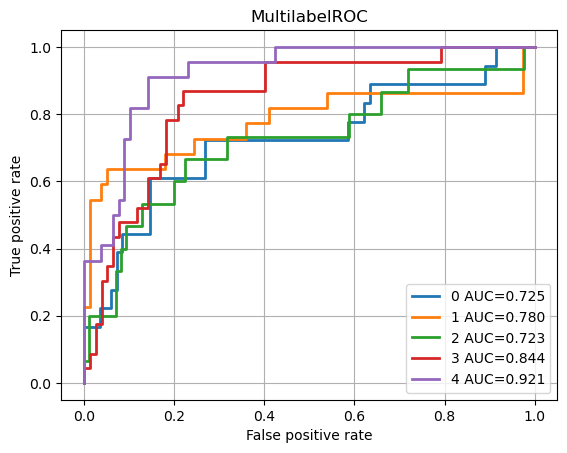

In [62]:
trainer.test(qClassifier, dataloaders=DataLoader(test_dataset))

TODO:

implement other metrics (accuracy)

implement equivariant checking

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/